# Configuracion de grafica a usar

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# lA ID de la GPU a usar, puede ser desde 0 hasta las N GPU's. Si es -1 significa que es en la CPU
os.environ["CUDA_VISIBLE_DEVICES"]="1";

# Importacion de librerias

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from IPython.display import display, clear_output

%matplotlib inline
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from Datasets_utils.DatasetsLoader import VideoDataGenerator

# Configuraciones para Tensorflow y Keras

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
tf.debugging.set_log_device_placement(False)

In [6]:
#Comprobar que estoy ejecutandome en modo eagerly
tf.executing_eagerly()

True

# Carga de Datos

In [7]:
root_path = "/home/jefelitman/DataSets/jhmdb/subset_split_1"
root_path

'/home/jefelitman/DataSets/jhmdb/subset_split_1'

In [8]:
batch_size = 4
original_size = [320, 240]
size = [320, 240]
frames = 16
canales = 3

In [9]:
def custom_temp_crop(frames):
    mitad = len(frames)//2
    paso = len(frames)//16
    indices = sorted(list(range(mitad, -1,-paso)) + list(range(mitad+paso, len(frames),paso)))
    indices = indices[len(indices)//2 - 8 : len(indices)//2 + 8]
    return [[frames[i] for i in indices]]

In [ ]:
def half_video_temporal(frames):
    mitad = len(frames)//2
    return [frames[mitad-8:mitad+8]]

In [10]:
dataset = VideoDataGenerator(directory_path = root_path, 
                             batch_size = batch_size, 
                             original_frame_size = original_size, 
                             frame_size=size, 
                             video_frames = frames, 
                             temporal_crop = ("custom", half_video_temporal), 
                             frame_crop = ("random", 1), 
                             shuffle = True, 
                             conserve_original = False)

# Red Neuronal LTC

### Construccion del modelo

In [11]:
#Entrada de la red neuronal
video_shape = tuple([frames]+size[::-1]+[canales])
dropout = 0.5
lr = 1e-3

ltc_save_path = '/home/jefelitman/Saved_Models/trained_jhmdb/LTC/subset1_{w}x{h}x{f}_softmax_sgd_'.format(
        w=size[0], h=size[1],f=frames)
if canales == 3:
    ltc_save_path += 'RGB_'
else:
    ltc_save_path += 'B&N_'

ltc_save_path +=  'lr=Lip'

#Creacion de la carpeta donde se salvara el modelo
if not os.path.isdir(ltc_save_path):
    os.mkdir(ltc_save_path)
model_saves_path = os.path.join(ltc_save_path,'model_saves')
if not os.path.isdir(model_saves_path):
    os.mkdir(model_saves_path)

In [12]:
#Parametros para la compilacion del modelo
optimizador = keras.optimizers.SGD(learning_rate=lr)
perdida = keras.losses.SparseCategoricalCrossentropy()
precision = keras.metrics.SparseCategoricalAccuracy()

In [13]:
entrada = keras.Input(shape=video_shape,
                     name="Input_video")
#Conv1
x = keras.layers.Conv3D(filters=64, kernel_size=3, padding="same", activation="relu", 
                          kernel_regularizer=keras.regularizers.l2(weigh_decay),
                          name='conv3d_1')(entrada)
x = keras.layers.MaxPool3D(pool_size=(1,2,2),strides=(1,2,2), name='max_pooling3d_1')(x)

#Conv2
x = keras.layers.Conv3D(filters=128, kernel_size=3, padding="same", activation="relu", 
                      kernel_regularizer=keras.regularizers.l2(weigh_decay),
                      name='conv3d_2')(x)
x = keras.layers.MaxPool3D(pool_size=(2,2,2),strides=(2,2,2), name='max_pooling3d_2')(x)

#Conv3
x = keras.layers.Conv3D(filters=256, kernel_size=3, padding="same", activation="relu", 
                      kernel_regularizer=keras.regularizers.l2(weigh_decay),
                      name='conv3d_3')(x)
x = keras.layers.MaxPool3D(pool_size=(2,2,2),strides=(2,2,2),name='max_pooling3d_3')(x)

#Conv4
x = keras.layers.Conv3D(filters=256, kernel_size=3, padding="same", activation="relu", 
                      kernel_regularizer=keras.regularizers.l2(weigh_decay),
                      name='conv3d_4')(x)
x = keras.layers.MaxPool3D(pool_size=(2,2,2),strides=(2,2,2),name='max_pooling3d_4')(x)

#Conv5
x = keras.layers.Conv3D(filters=256, kernel_size=3, padding="same", activation="relu", 
                      kernel_regularizer=keras.regularizers.l2(weigh_decay),
                      name='conv3d_5')(x)
x = keras.layers.MaxPool3D(pool_size=(2,2,2),strides=(2,2,2),name='max_pooling3d_5')(x)

#fc6s
x = keras.layers.Flatten(name='flatten_6')(x)
x = keras.layers.Dense(2048, activation="relu", kernel_regularizer=keras.regularizers.l2(weigh_decay),
                     name='dense_6')(x)
x = keras.layers.Dropout(rate=dropout,name='dropout_6')(x)

#fc7
x = keras.layers.Dense(2048, activation="relu", kernel_regularizer=keras.regularizers.l2(weigh_decay),
                     name='dense_7')(x)
x = keras.layers.Dropout(rate=dropout,name='dropout_7')(x)

#fc8
salidas = keras.layers.Dense(len(dataset.to_class), activation="softmax", 
                          kernel_regularizer=keras.regularizers.l2(weigh_decay), name='dense_8')(x)

ltc = keras.Model(entrada, salidas, name="LTC")

In [14]:
#ltc = keras.models.load_model(os.path.join(ltc_save_path,'ltc_final_200.h5'))

In [15]:
#Compilacion del modelo
ltc.compile(optimizer = optimizador,
           loss = perdida,
           metrics = [precision])

In [16]:
#keras.utils.plot_model(ltc, 'LTC.png', show_shapes=True)

In [17]:
ltc.summary()

Model: "LTC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_video (InputLayer)     [(None, 16, 240, 320, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 16, 240, 320, 64)  5248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 120, 160, 64)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 120, 160, 128) 221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 80, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 80, 256)    884992    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 30, 40, 256)    0       

### Entrenamiento de la red paso a paso

In [18]:
epochs = 30
train_loss = []
train_accuracy = []
eval_loss = []
eval_accuracy = []
maximo = -1
step_max = 0

In [19]:
for train_epoch in range(epochs):
    #Momento de entrenar primero
    keras.backend.set_learning_phase(True)
    valores_l =[]
    for step in range(dataset.train_batches):
        with tf.device('/GPU:0'):
            batch, labels = dataset.get_next_train_batch(canales)
            with tf.GradientTape() as tape:
                predicciones = ltc(batch)
                valor_perdida = perdida(labels, predicciones)
                
            grads = tape.gradient(valor_perdida, ltc.trainable_weights)
            optimizador.apply_gradients(zip(grads, ltc.trainable_weights))

        with tf.device('/CPU:0'):
            #Agrego los valores a L
            for i,l in enumerate(labels):
                valores_l.append(1/predicciones[i,l].numpy())
            precision.update_state(labels, predicciones)

            if precision.result().numpy() >= maximo:
                if precision.result().numpy() - maximo >= 0.1:
                    ltc.save(os.path.join(model_saves_path,'ltc_epoch_{i}.h5'.format(i=train_epoch+1)))
                maximo = precision.result().numpy()
                step_max = step+1

            clear_output(wait=True)
            print("Step: ",step+1, " Learning rate: ", optimizador.lr.numpy())
            print("Train Epoch: ",train_epoch+1, " Train batch: ",dataset.train_batch_index,"/",dataset.train_batches)
            print("Train_Loss: ",valor_perdida.numpy()," Train_Accuracy: ",precision.result().numpy())
            print("Tain_max_Accuracy: {m} at the step: {s} in the epoch: {e}".format(m=maximo, s=step_max, e=train_epoch+1))
            if train_epoch != 0 and step != 0:
                print("Epoch: {e} - Eval_Loss: {l} Eval_Accuracy: {a}".format(e=train_epoch,l=eval_loss[-1],a=eval_accuracy[-1]))
            print("Value of L = {n}".format(n = np.mean(valores_l)))

    with tf.device('/CPU:0'):
        #Actualizacion del valor del lr segun lipschitz
        L = np.mean(valores_l)
        keras.backend.set_value(optimizador.lr, 1/L)
        
        train_loss.append(valor_perdida.numpy())
        train_accuracy.append(precision.result().numpy())
        precision.reset_states()
                
    keras.backend.set_learning_phase(False)
    for step in range(dataset.test_batches):
        with tf.device('/GPU:0'):
            batch, labels = dataset.get_next_test_batch(canales)
            predicciones = ltc(batch)
            valor_perdida_eval = perdida(labels, predicciones)
            precision.update_state(labels, predicciones)
        
    with tf.device('/CPU:0'):
        eval_loss.append(valor_perdida_eval.numpy())
        eval_accuracy.append(precision.result().numpy())
        precision.reset_states()

Step:  57  Learning rate:  0.082628265
Train Epoch:  100  Train batch:  57 / 57
Train_Loss:  2.3864403  Train_Accuracy:  0.13157895
Tain_max_Accuracy: 0.5 at the step: 1 in the epoch: 100
Epoch: 99 - Eval_Loss: 2.5839881896972656 Eval_Accuracy: 0.1304347813129425
Value of L = 12.102395820911868


### Guardado del modelo 

In [20]:
#Salvado final definitivo del modelo una vez se detenga
ltc.save(os.path.join(ltc_save_path,"ltc_final_{e}.h5".format(e=epochs)))

### Graficas de los resultados de entrenamiento

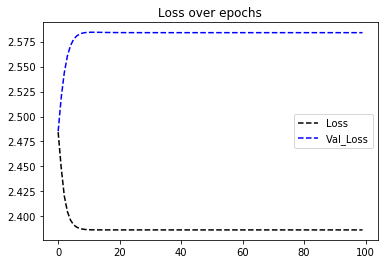

In [21]:
fig = plt.figure()
plt.plot(train_loss,'k--')
plt.plot(eval_loss,'b--')
plt.title('Loss over epochs')
plt.legend(labels=["Loss","Val_Loss"])
plt.show()
fig.savefig(os.path.join(ltc_save_path,'train_loss_epoch_{e}.png'.format(e=epochs)))

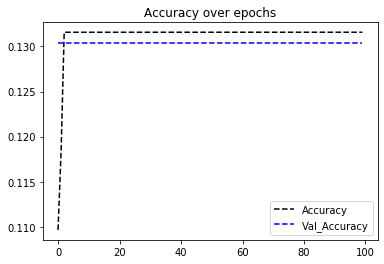

In [22]:
fig = plt.figure()
plt.plot(train_accuracy,'k--')
plt.plot(eval_accuracy,'b--')
plt.title('Accuracy over epochs')
plt.legend(labels=["Accuracy","Val_Accuracy"])
plt.show()
fig.savefig(os.path.join(ltc_save_path,'train_accuracy_epoch_{e}.png'.format(e=epochs)))

### Evaluacion del entrenamiento